# Random Forest: Predicting ENVO Local Scale from Google Earth Embeddings

This notebook trains a Random Forest classifier to predict environmental ontology (ENVO) local scale terms from Google Earth Engine satellite embeddings.

**Question**: Can geographic/satellite imagery data predict environmental classification labels?

## Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

## Load and Prepare Data

In [2]:
# Load the NMDC complete dataset
df = pd.read_csv('../data/nmdc_flattened_biosample_for_env_embeddings_202510061052_complete.csv')

print(f"Total rows: {len(df)}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Total rows: 8121
Columns: ['accession', 'collection_date', 'latitude', 'longitude', 'env_broad_scale', 'env_local_scale', 'env_medium', 'google_earth_embeddings', 'envo_broad_scale_embedding', 'envo_medium_embedding', 'envo_local_scale_embedding']

First few rows:


,accession,collection_date,latitude,longitude,env_broad_scale,env_local_scale,env_medium,google_earth_embeddings,envo_broad_scale_embedding,envo_medium_embedding,envo_local_scale_embedding
0,nmdc:bsm-11-ywtc8b82,2017-03-07,38.917216,-106.955995,ENVO:01000177,ENVO:00000292,ENVO:00005802,"[-0.08882737408688965, -0.2364628988850442, -0...","[0.03509042412042618, 0.02636082097887993, 0.0...","[0.028898712247610092, 0.02002768963575363, 0....","[0.014175891876220703, 0.03145849332213402, 0...."
1,nmdc:bsm-11-xcyvst62,2017-03-07,38.917216,-106.955995,ENVO:01000177,ENVO:00000292,ENVO:00005802,"[-0.08882737408688965, -0.2364628988850442, -0...","[0.03509042412042618, 0.02636082097887993, 0.0...","[0.028898712247610092, 0.02002768963575363, 0....","[0.014175891876220703, 0.03145849332213402, 0...."
2,nmdc:bsm-11-1srsh991,2017-03-07,38.917216,-106.955995,ENVO:01000177,ENVO:00000292,ENVO:00005802,"[-0.08882737408688965, -0.2364628988850442, -0...","[0.03509042412042618, 0.02636082097887993, 0.0...","[0.028898712247610092, 0.02002768963575363, 0....","[0.014175891876220703, 0.03145849332213402, 0...."
3,nmdc:bsm-11-2nqe9j19,2017-03-07,38.920400,-106.948287,ENVO:01000177,ENVO:00000292,ENVO:00005802,"[-0.06698961937716265, -0.2364628988850442, -0...","[0.03509042412042618, 0.02636082097887993, 0.0...","[0.028898712247610092, 0.02002768963575363, 0....","[0.014175891876220703, 0.03145849332213402, 0...."
4,nmdc:bsm-11-39j0y956,2017-03-07,38.920400,-106.948287,ENVO:01000177,ENVO:00000292,ENVO:00005802,"[-0.06698961937716265, -0.2364628988850442, -0...","[0.03509042412042618, 0.02636082097887993, 0.0...","[0.028898712247610092, 0.02002768963575363, 0....","[0.014175891876220703, 0.03145849332213402, 0...."


In [3]:
print("=== DEDUPLICATION COMPARISON ===\n")

# Save version with all duplicates
df_with_duplicates = df.copy()
print(f"Version A (with duplicates): {len(df_with_duplicates)} samples")

# Create deduplicated version: remove EXACT replicates only
# (same coords AND same ENVO triad)
df_deduped = df.drop_duplicates(
    subset=['latitude', 'longitude', 'collection_date',
            'env_broad_scale', 'env_local_scale', 'env_medium'],
    keep='first'  # Keep first occurrence of each unique combination
).copy()

removed = len(df) - len(df_deduped)
print(f"Version B (deduplicated): {len(df_deduped)} samples")
print(f"Removed exact replicates: {removed} ({removed/len(df)*100:.1f}%)\n")

# Show what we kept
coords_with_different_envo = len(df_deduped.groupby(['latitude', 'longitude', 'collection_date']).filter(lambda x: len(x) > 1))
print(f"Samples with same coords but different ENVO (kept): {coords_with_different_envo}")
print(f"These represent temporal/spatial variation or annotation uncertainty\n")

print("We will run the full analysis pipeline for BOTH versions and compare results.")

=== DEDUPLICATION COMPARISON ===

Version A (with duplicates): 8121 samples
Version B (deduplicated): 4646 samples
Removed exact replicates: 3475 (42.8%)

Samples with same coords but different ENVO (kept): 367
These represent temporal/spatial variation or annotation uncertainty

We will run the full analysis pipeline for BOTH versions and compare results.


### Deduplication Strategy (Issue #54)

**Scientific approach**: Run analysis BOTH ways and compare results.

**Version A - With duplicates** (all samples):
- Includes "repeated evidence" from technical replicates
- Includes conflicts (same coords, different ENVO) which may represent real variation

**Version B - Deduplicated** (exact replicates only):
- Remove only exact duplicates: same coords AND same ENVO triad
- Keep conflicts: same coords, different ENVO (important signal!)
- Prevents pseudo-replication

**What we keep vs remove**:
- ✅ Keep: (lat,lon,date) → ENVO_A and (lat,lon,date) → ENVO_B (different annotations = signal)
- ❌ Remove: (lat,lon,date) → ENVO_A and (lat,lon,date) → ENVO_A (exact duplicate = pseudo-replication)

In [4]:
print("=== DUPLICATE COORDINATE ANALYSIS ===\n")
print(f"Original dataset: {len(df)} samples\n")

# Group by coordinate + date to find duplicates
coord_groups = df.groupby(['latitude', 'longitude', 'collection_date'])
coord_counts = coord_groups.size()

# Count duplicates
n_unique_coords = len(coord_counts)
n_duplicate_coords = (coord_counts > 1).sum()
n_duplicate_samples = (coord_counts - 1).sum()  # Additional samples beyond first

print(f"Unique coordinates: {n_unique_coords}")
print(f"Coordinates with duplicates: {n_duplicate_coords} ({n_duplicate_coords/n_unique_coords*100:.1f}%)")
print(f"Total duplicate samples: {n_duplicate_samples} ({n_duplicate_samples/len(df)*100:.1f}%)\n")

# Analyze ENVO annotation agreement
print("=== ANNOTATION AGREEMENT ===\n")

technical_replicates = 0
annotation_conflicts = 0
conflict_details = []

for (lat, lon, date), group in coord_groups:
    if len(group) > 1:
        # Check if all samples have same ENVO triad
        unique_triads = group[['env_broad_scale', 'env_local_scale', 'env_medium']].drop_duplicates()

        if len(unique_triads) == 1:
            # All samples have same ENVO annotations - technical replicate
            technical_replicates += 1
        else:
            # Samples have different ENVO annotations - conflict!
            annotation_conflicts += 1
            conflict_details.append({
                'coord': (lat, lon, date),
                'n_samples': len(group),
                'triads': unique_triads.to_dict('records'),
                'accessions': group['accession'].tolist()
            })

print(f"Technical replicates (same ENVO): {technical_replicates} coordinates")
print(f"Annotation conflicts (different ENVO): {annotation_conflicts} coordinates\n")

# Show examples of conflicts
if annotation_conflicts > 0:
    print(f"=== EXAMPLE CONFLICTS ===\n")
    for i, conflict in enumerate(conflict_details[:3], 1):  # Show first 3
        print(f"Conflict {i}: {conflict['n_samples']} samples at {conflict['coord']}")
        for j, triad in enumerate(conflict['triads'], 1):
            print(f"  Triad {j}: broad={triad['env_broad_scale']}, local={triad['env_local_scale']}, medium={triad['env_medium']}")
        print(f"  Samples: {', '.join(conflict['accessions'][:5])}")
        print()

=== DUPLICATE COORDINATE ANALYSIS ===

Original dataset: 8121 samples

Unique coordinates: 4451
Coordinates with duplicates: 492 (11.1%)
Total duplicate samples: 3670 (45.2%)

=== ANNOTATION AGREEMENT ===

Technical replicates (same ENVO): 320 coordinates
Annotation conflicts (different ENVO): 172 coordinates

=== EXAMPLE CONFLICTS ===

Conflict 1: 28 samples at (np.float64(-37.796972960817214), np.float64(144.95895892649088), '2023-05-30')
  Triad 1: broad=ENVO:01001001, local=ENVO:00005801, medium=ENVO:01000349
  Triad 2: broad=ENVO:01001001, local=ENVO:01000621, medium=ENVO:00005791
  Samples: nmdc:bsm-11-g2h93009, nmdc:bsm-11-8b4rh852, nmdc:bsm-11-mz5hxz22, nmdc:bsm-11-vpyyfy41, nmdc:bsm-11-zaw2am78

Conflict 2: 3 samples at (np.float64(14.8084), np.float64(-87.9952), '2020-01-06')
  Triad 1: broad=ENVO:01000252, local=ENVO:00002131, medium=ENVO:04000007
  Triad 2: broad=ENVO:01000252, local=ENVO:00002132, medium=ENVO:04000007
  Triad 3: broad=ENVO:01000252, local=ENVO:00002130, me

## Duplicate Coordinate Analysis (Issue #54)

**Problem**: Multiple samples can have identical coordinates + dates → identical Google Earth embeddings.

This creates two issues:
1. **Technical replicates** (same ENVO annotations): Inflates dataset via pseudo-replication
2. **Annotation conflicts** (different ENVO annotations): Creates impossible learning task (X → Y₁ AND X → Y₂)

We quantify duplicates, identify conflicts, and run the full pipeline for BOTH versions (with and without exact duplicates) to compare results.

In [5]:
# Use deduplicated version for main analysis
df = df_deduped

# Check for missing values in key columns
print("Missing values:")
print(df[['google_earth_embeddings', 'env_local_scale']].isna().sum())

# Filter to rows with both embeddings and labels
df_clean = df[df['google_earth_embeddings'].notna() & df['env_local_scale'].notna()].copy()
print(f"\nRows with both Google Earth embeddings and env_local_scale: {len(df_clean)}")

Missing values:
google_earth_embeddings    0
env_local_scale            0
dtype: int64

Rows with both Google Earth embeddings and env_local_scale: 4646


## Parse Embeddings

In [6]:
def parse_embedding(embedding_str):
    """
    Parse embedding string to numpy array.

    Args:
        embedding_str: String representation of embedding list

    Returns:
        numpy array of embedding values
    """
    try:
        if isinstance(embedding_str, str):
            embedding_list = ast.literal_eval(embedding_str)
        else:
            embedding_list = embedding_str
        return np.array(embedding_list, dtype=np.float32)
    except Exception as e:
        print(f"Error parsing embedding: {e}")
        return None

# Parse Google Earth embeddings
print("Parsing Google Earth embeddings...")
df_clean['ge_embedding'] = df_clean['google_earth_embeddings'].apply(parse_embedding)

# Remove any rows where parsing failed
df_clean = df_clean[df_clean['ge_embedding'].notna()].copy()

print(f"Rows with valid embeddings: {len(df_clean)}")
if len(df_clean) > 0:
    embedding_dim = len(df_clean.iloc[0]['ge_embedding'])
    print(f"Google Earth embedding dimension: {embedding_dim}")

Parsing Google Earth embeddings...
Rows with valid embeddings: 4646
Google Earth embedding dimension: 64


## Explore Target Variable

In [7]:
# Examine env_local_scale values
print("=== TARGET VARIABLE: env_local_scale ===")
print(f"\nUnique values: {df_clean['env_local_scale'].nunique()}")
print(f"\nValue counts:")
value_counts = df_clean['env_local_scale'].value_counts()
print(value_counts)

# Show some examples
print(f"\nExample values:")
for val in df_clean['env_local_scale'].unique()[:10]:
    print(f"  - {val}")

=== TARGET VARIABLE: env_local_scale ===

Unique values: 51

Value counts:
env_local_scale
ENVO:01000843    1002
ENVO:01000816     739
ENVO:01000888     583
ENVO:01000869     485
ENVO:00000114     203
ENVO:00000022     184
ENVO:01000893     161
ENVO:01000855     132
ENVO:00005801     107
ENVO:01000892     106
ENVO:00000011     103
ENVO:01001057      99
ENVO:03605007      89
ENVO:01000891      87
ENVO:00002131      87
ENVO:01000887      82
ENVO:01000861      65
ENVO:00000148      55
ENVO:03600095      46
ENVO:01000894      31
ENVO:03600094      30
ENVO:01000409      19
ENVO:00000292      18
ENVO:01001191      14
ENVO:01000297      13
ENVO:00000021      12
ENVO:00002269       9
ENVO:01001206       8
ENVO:00000469       7
ENVO:01001442       7
ENVO:00002000       7
ENVO:03600096       7
ENVO:01001357       6
ENVO:00000100       5
ENVO:01000621       5
ENVO:00000078       5
ENVO:00002130       4
ENVO:00002132       3
ENVO:03600018       2
ENVO:00000083       2
ENVO:00000182       2
ENVO:00

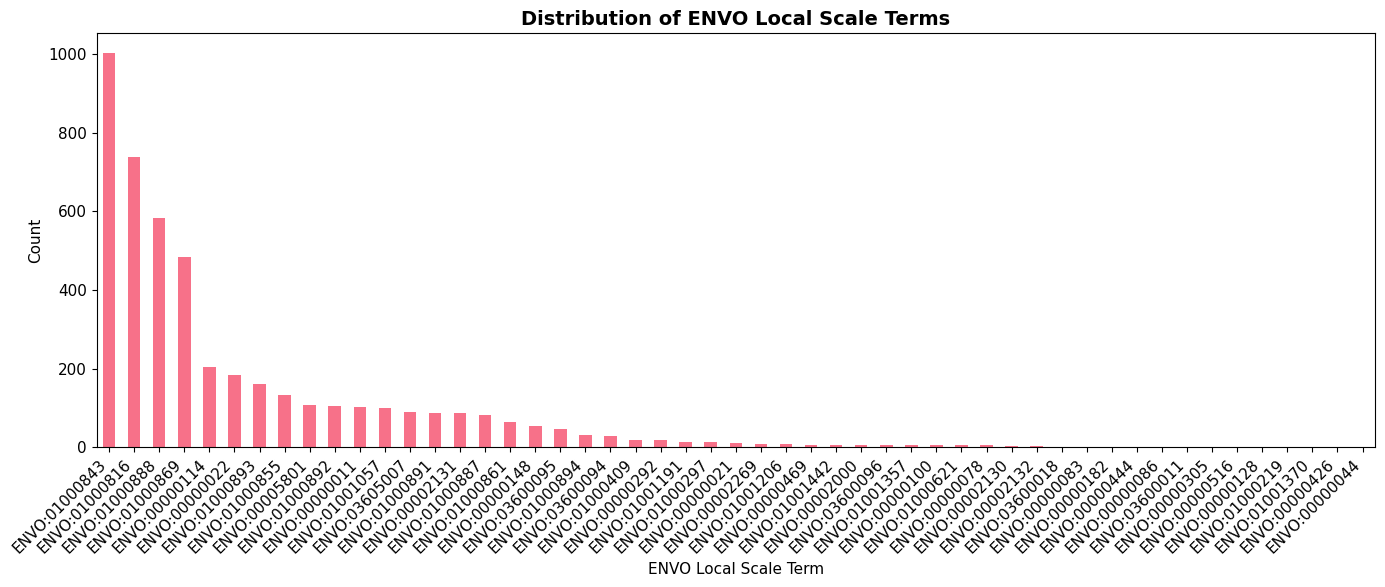


Class balance analysis:
Most common class: 1002 samples (21.6%)
Least common class: 1 samples (0.0%)


In [8]:
# Visualize class distribution
fig, ax = plt.subplots(figsize=(14, 6))
value_counts.plot(kind='bar', ax=ax)
ax.set_title('Distribution of ENVO Local Scale Terms', fontsize=14, fontweight='bold')
ax.set_xlabel('ENVO Local Scale Term')
ax.set_ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\nClass balance analysis:")
print(f"Most common class: {value_counts.iloc[0]} samples ({value_counts.iloc[0]/len(df_clean)*100:.1f}%)")
print(f"Least common class: {value_counts.iloc[-1]} samples ({value_counts.iloc[-1]/len(df_clean)*100:.1f}%)")

## Prepare Features and Labels

In [9]:
# Create feature matrix X from embeddings
X = np.vstack(df_clean['ge_embedding'].values)
print(f"Feature matrix shape: {X.shape}")

# Create target vector y
y = df_clean['env_local_scale'].values
print(f"Target vector shape: {y.shape}")

print(f"\nNumber of samples: {len(X)}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {len(np.unique(y))}")

Feature matrix shape: (4646, 64)
Target vector shape: (4646,)

Number of samples: 4646
Number of features: 64
Number of classes: 51


## Train/Test Split

In [10]:
# Determine if stratification is possible
min_class_count = value_counts.min()
use_stratify = min_class_count >= 2  # Need at least 2 samples per class for stratification

print(f"Minimum class count: {min_class_count}")
print(f"Using stratified split: {use_stratify}")

# Split the data
test_size = 0.2
if use_stratify:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=RANDOM_STATE, stratify=y
    )
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=RANDOM_STATE
    )

print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTraining set class distribution:")
print(pd.Series(y_train).value_counts())

Minimum class count: 1
Using stratified split: False

Training set: 3716 samples
Test set: 930 samples

Training set class distribution:
ENVO:01000843    803
ENVO:01000816    606
ENVO:01000888    468
ENVO:01000869    391
ENVO:00000114    161
ENVO:00000022    146
ENVO:01000893    125
ENVO:01000855    109
ENVO:00005801     82
ENVO:01000892     80
ENVO:01001057     76
ENVO:01000891     74
ENVO:00000011     73
ENVO:00002131     72
ENVO:01000887     66
ENVO:03605007     60
ENVO:01000861     52
ENVO:00000148     46
ENVO:03600095     37
ENVO:01000894     27
ENVO:03600094     25
ENVO:00000292     15
ENVO:01000409     14
ENVO:01000297     11
ENVO:00002269      8
ENVO:01001191      8
ENVO:00000021      8
ENVO:00002000      7
ENVO:01001206      7
ENVO:01001442      7
ENVO:03600096      6
ENVO:01001357      6
ENVO:00000100      5
ENVO:00000078      5
ENVO:01000621      5
ENVO:00000469      4
ENVO:00002132      3
ENVO:00002130      3
ENVO:03600018      2
ENVO:00000182      2
ENVO:00000086      2
EN

## Train Random Forest Classifier

In [11]:
# Train Random Forest
print("Training Random Forest Classifier...")
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_classifier.fit(X_train, y_train)
print("Training complete!")

Training Random Forest Classifier...
Training complete!


## Model Evaluation

In [12]:
# Make predictions
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("=== MODEL PERFORMANCE ===")
print(f"Training accuracy: {train_accuracy:.3f}")
print(f"Test accuracy: {test_accuracy:.3f}")
print(f"\nDifference (overfitting check): {train_accuracy - test_accuracy:.3f}")

=== MODEL PERFORMANCE ===
Training accuracy: 0.934
Test accuracy: 0.834

Difference (overfitting check): 0.100


In [13]:
# Cross-validation on training set
if len(X_train) >= 5:  # Need enough samples for CV
    cv_folds = min(5, len(X_train))
    print(f"\n=== CROSS-VALIDATION ({cv_folds}-fold) ===")
    cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=cv_folds, scoring='accuracy')
    print(f"CV Accuracy scores: {cv_scores}")
    print(f"Mean CV accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
else:
    print("\nDataset too small for cross-validation")


=== CROSS-VALIDATION (5-fold) ===
CV Accuracy scores: [0.84677419 0.84522207 0.8371467  0.83580081 0.85598923]
Mean CV accuracy: 0.844 (+/- 0.015)


In [14]:
# Detailed classification report
print("\n=== CLASSIFICATION REPORT (Test Set) ===")
print(classification_report(y_test, y_test_pred, zero_division=0))


=== CLASSIFICATION REPORT (Test Set) ===
               precision    recall  f1-score   support

ENVO:00000011       0.00      0.00      0.00        30
ENVO:00000021       0.00      0.00      0.00         4
ENVO:00000022       0.72      0.61      0.66        38
ENVO:00000083       0.00      0.00      0.00         1
ENVO:00000114       1.00      0.98      0.99        42
ENVO:00000148       0.20      0.11      0.14         9
ENVO:00000292       1.00      1.00      1.00         3
ENVO:00000305       0.00      0.00      0.00         1
ENVO:00000444       0.00      0.00      0.00         1
ENVO:00000469       1.00      1.00      1.00         3
ENVO:00000516       1.00      1.00      1.00         1
ENVO:00002130       0.00      0.00      0.00         1
ENVO:00002131       0.70      0.93      0.80        15
ENVO:00002269       0.00      0.00      0.00         1
ENVO:00005801       0.03      0.04      0.04        25
ENVO:01000219       0.00      0.00      0.00         1
ENVO:01000297       0.

## Confusion Matrix

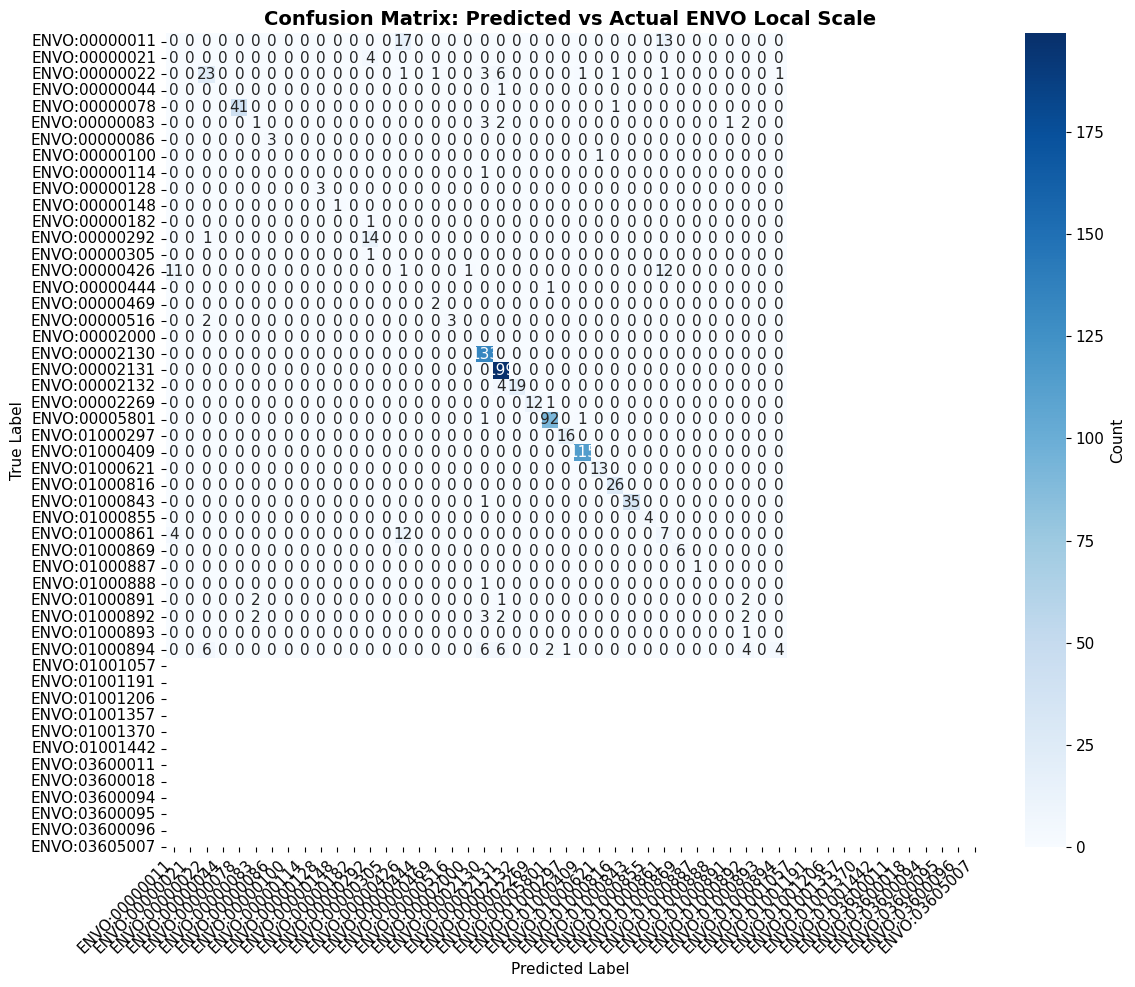

In [15]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
class_labels = rf_classifier.classes_

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            ax=ax, cbar_kws={'label': 'Count'})
ax.set_title('Confusion Matrix: Predicted vs Actual ENVO Local Scale',
             fontsize=14, fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Feature Importance

In [16]:
# Get feature importances
feature_importances = rf_classifier.feature_importances_
feature_names = [f"GE_dim_{i}" for i in range(len(feature_importances))]

# Sort by importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print("=== TOP 20 MOST IMPORTANT FEATURES ===")
print(importance_df.head(20))

=== TOP 20 MOST IMPORTANT FEATURES ===
      feature  importance
14  GE_dim_14    0.040915
18  GE_dim_18    0.035716
37  GE_dim_37    0.034749
33  GE_dim_33    0.032679
5    GE_dim_5    0.029707
27  GE_dim_27    0.027158
34  GE_dim_34    0.027157
39  GE_dim_39    0.025360
11  GE_dim_11    0.025161
46  GE_dim_46    0.025158
0    GE_dim_0    0.023906
26  GE_dim_26    0.023714
48  GE_dim_48    0.023087
24  GE_dim_24    0.020315
22  GE_dim_22    0.019242
43  GE_dim_43    0.018817
35  GE_dim_35    0.017846
21  GE_dim_21    0.017525
10  GE_dim_10    0.017446
56  GE_dim_56    0.017076


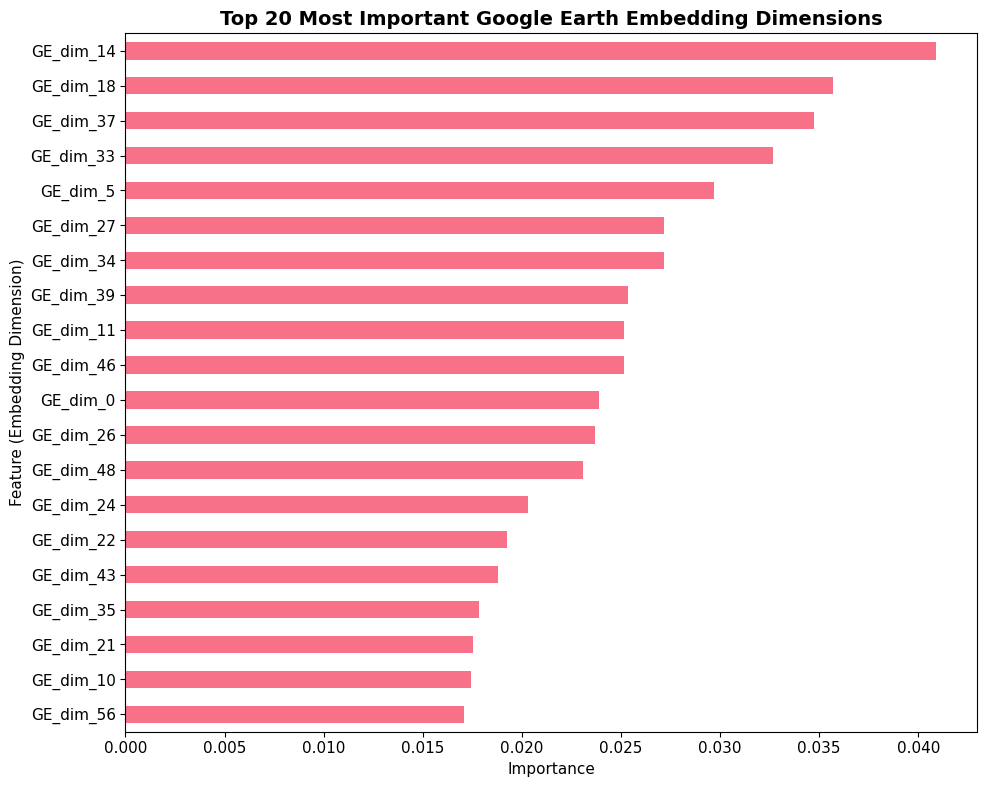

In [17]:
# Plot top 20 feature importances
top_n = 20
fig, ax = plt.subplots(figsize=(10, 8))
importance_df.head(top_n).plot(x='feature', y='importance', kind='barh', ax=ax, legend=False)
ax.set_title(f'Top {top_n} Most Important Google Earth Embedding Dimensions',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature (Embedding Dimension)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## Feature Importance Comparison Across ENVO Scales (Issue #53)

**Question**: Do different ENVO scales (broad/local/medium) rely on different Google Earth embedding dimensions?

We'll train Random Forest classifiers for all three ENVO scales and compare their feature importance patterns.

In [18]:
# Train RF classifiers for all three ENVO scales
print("=== TRAINING RF CLASSIFIERS FOR ALL ENVO SCALES ===\n")

rf_models = {}
feature_importances_all = {}
test_accuracies = {}

for scale in ['env_broad_scale', 'env_local_scale', 'env_medium']:
    print(f"Training RF for {scale}...")

    # Prepare target
    y_scale = df_clean[scale].values

    # Split data
    X_train_scale, X_test_scale, y_train_scale, y_test_scale = train_test_split(
        X, y_scale, test_size=0.2, random_state=RANDOM_STATE
    )

    # Train model
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    rf.fit(X_train_scale, y_train_scale)

    # Evaluate
    y_pred_scale = rf.predict(X_test_scale)
    accuracy = accuracy_score(y_test_scale, y_pred_scale)

    # Store results
    rf_models[scale] = rf
    feature_importances_all[scale] = rf.feature_importances_
    test_accuracies[scale] = accuracy

    print(f"  {scale}: {df_clean[scale].nunique()} classes, test accuracy = {accuracy:.3f}\n")

print("Training complete!")


=== TRAINING RF CLASSIFIERS FOR ALL ENVO SCALES ===

Training RF for env_broad_scale...
  env_broad_scale: 19 classes, test accuracy = 0.919

Training RF for env_local_scale...
  env_local_scale: 51 classes, test accuracy = 0.834

Training RF for env_medium...
  env_medium: 30 classes, test accuracy = 0.826

Training complete!


In [19]:
from scipy.stats import spearmanr

# Create dataframe with all importances
importance_comparison_df = pd.DataFrame({
    'feature': [f"GE_dim_{i}" for i in range(64)],
    'broad_scale': feature_importances_all['env_broad_scale'],
    'local_scale': feature_importances_all['env_local_scale'],
    'medium': feature_importances_all['env_medium']
})

# Show top 10 features for each scale
print("=== FEATURE IMPORTANCE COMPARISON ===\n")
print("Top 10 features by importance for each ENVO scale:\n")
for scale in ['broad_scale', 'local_scale', 'medium']:
    top_features = importance_comparison_df.nlargest(10, scale)[['feature', scale]]
    print(f"{scale.upper()}:")
    print(top_features.to_string(index=False))
    print()

# Calculate correlation between importance rankings
print("\n=== SPEARMAN CORRELATION OF FEATURE IMPORTANCE RANKINGS ===")
print(f"Broad vs Local:  ρ = {spearmanr(importance_comparison_df['broad_scale'], importance_comparison_df['local_scale'])[0]:.3f}")
print(f"Broad vs Medium: ρ = {spearmanr(importance_comparison_df['broad_scale'], importance_comparison_df['medium'])[0]:.3f}")
print(f"Local vs Medium: ρ = {spearmanr(importance_comparison_df['local_scale'], importance_comparison_df['medium'])[0]:.3f}")


=== FEATURE IMPORTANCE COMPARISON ===

Top 10 features by importance for each ENVO scale:

BROAD_SCALE:
  feature  broad_scale
GE_dim_39     0.066495
GE_dim_14     0.060594
GE_dim_21     0.047095
GE_dim_28     0.043622
GE_dim_47     0.041229
GE_dim_63     0.039645
GE_dim_29     0.035723
GE_dim_46     0.029417
GE_dim_25     0.027981
GE_dim_45     0.027171

LOCAL_SCALE:
  feature  local_scale
GE_dim_14     0.040915
GE_dim_18     0.035716
GE_dim_37     0.034749
GE_dim_33     0.032679
 GE_dim_5     0.029707
GE_dim_27     0.027158
GE_dim_34     0.027157
GE_dim_39     0.025360
GE_dim_11     0.025161
GE_dim_46     0.025158

MEDIUM:
  feature   medium
GE_dim_39 0.054754
GE_dim_14 0.049391
GE_dim_47 0.039660
GE_dim_28 0.037371
GE_dim_61 0.036735
GE_dim_21 0.034639
GE_dim_31 0.033266
GE_dim_63 0.033188
GE_dim_29 0.031290
GE_dim_30 0.030884


=== SPEARMAN CORRELATION OF FEATURE IMPORTANCE RANKINGS ===
Broad vs Local:  ρ = -0.014
Broad vs Medium: ρ = 0.805
Local vs Medium: ρ = -0.035


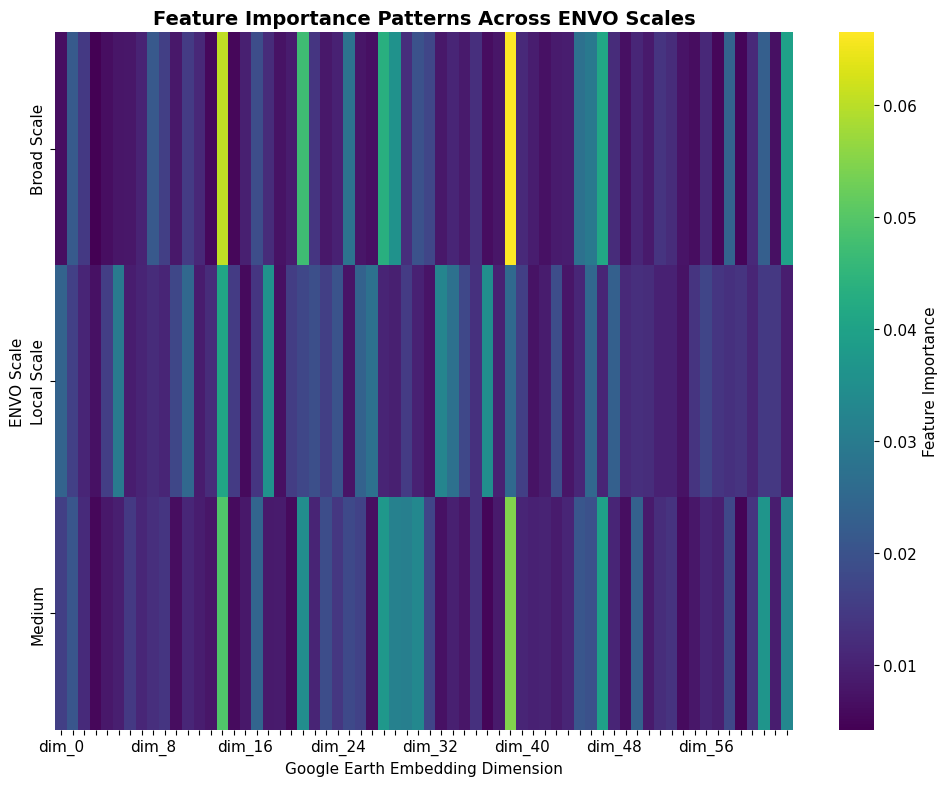


=== KEY INSIGHTS ===
Different ENVO scales show different feature importance patterns.

Test accuracies:
  env_broad_scale: 0.919
  env_local_scale: 0.834
  env_medium: 0.826


In [20]:
# Heatmap showing correlation of feature importances across scales
fig, ax = plt.subplots(figsize=(10, 8))

# Create correlation matrix of feature importances
importance_matrix = importance_comparison_df[['broad_scale', 'local_scale', 'medium']].T

sns.heatmap(importance_matrix,
            cmap='viridis',
            xticklabels=[f"dim_{i}" if i % 8 == 0 else "" for i in range(64)],
            yticklabels=['Broad Scale', 'Local Scale', 'Medium'],
            ax=ax,
            cbar_kws={'label': 'Feature Importance'})

ax.set_title('Feature Importance Patterns Across ENVO Scales', fontsize=14, fontweight='bold')
ax.set_xlabel('Google Earth Embedding Dimension')
ax.set_ylabel('ENVO Scale')

plt.tight_layout()
plt.show()

print("\n=== KEY INSIGHTS ===")
print(f"Different ENVO scales show {'similar' if spearmanr(importance_comparison_df['broad_scale'], importance_comparison_df['local_scale'])[0] > 0.7 else 'different'} feature importance patterns.")
print(f"\nTest accuracies:")
for scale in ['env_broad_scale', 'env_local_scale', 'env_medium']:
    print(f"  {scale}: {test_accuracies[scale]:.3f}")

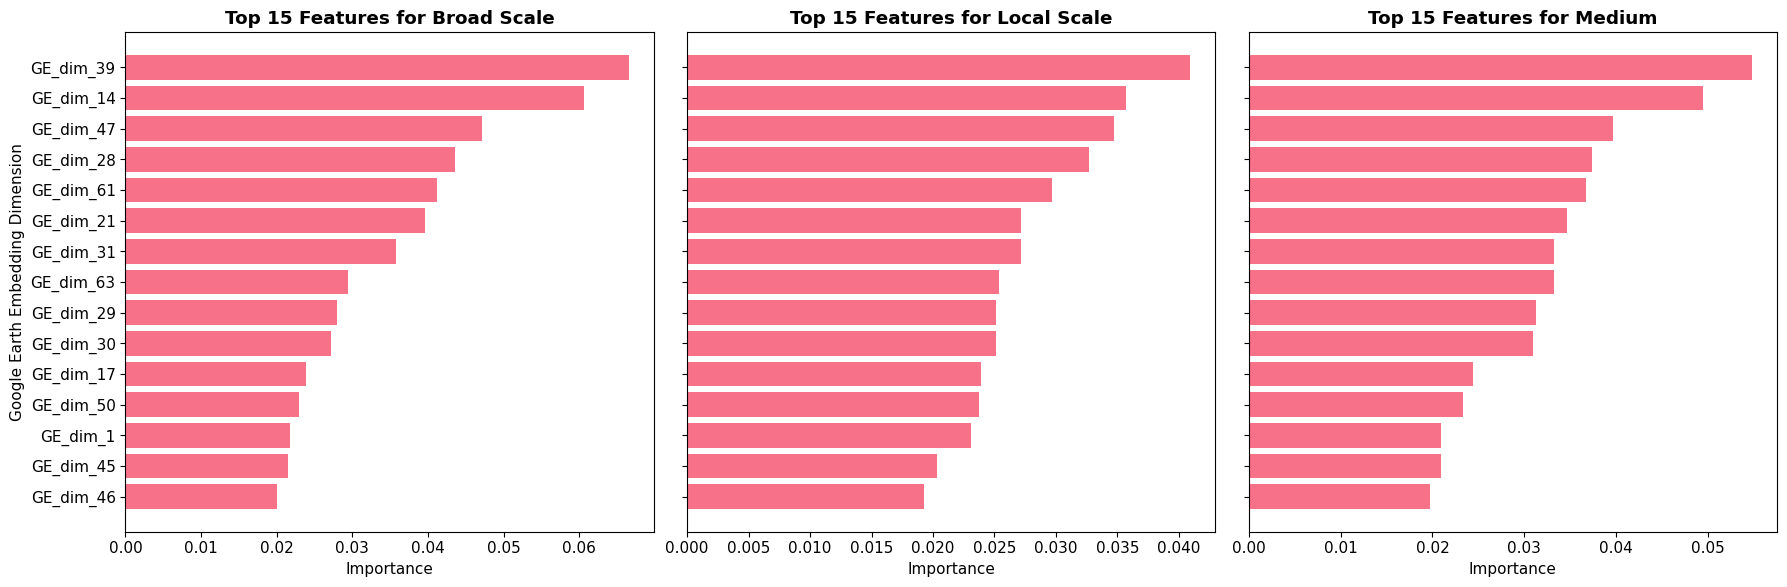

In [21]:
# Visualize feature importance comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

scales = ['broad_scale', 'local_scale', 'medium']
scale_labels = ['Broad Scale', 'Local Scale', 'Medium']

for idx, (scale, label) in enumerate(zip(scales, scale_labels)):
    top_n = 15
    top_features = importance_comparison_df.nlargest(top_n, scale)

    axes[idx].barh(range(top_n), top_features[scale].values)
    axes[idx].set_yticks(range(top_n))
    axes[idx].set_yticklabels(top_features['feature'].values)
    axes[idx].set_xlabel('Importance')
    axes[idx].set_title(f'Top {top_n} Features for {label}', fontweight='bold')
    axes[idx].invert_yaxis()

axes[0].set_ylabel('Google Earth Embedding Dimension')

plt.tight_layout()
plt.show()

In [22]:
# Compare feature importances across scales
print("=== FEATURE IMPORTANCE COMPARISON ===\n")

# Create dataframe with all importances
importance_comparison_df = pd.DataFrame({
    'feature': [f"GE_dim_{i}" for i in range(64)],
    'broad_scale': feature_importances_all['env_broad_scale'],
    'local_scale': feature_importances_all['env_local_scale'],
    'medium': feature_importances_all['env_medium']
})

# Show top 10 features for each scale
print("Top 10 features by importance for each ENVO scale:\n")
for scale in ['broad_scale', 'local_scale', 'medium']:
    top_features = importance_comparison_df.nlargest(10, scale)[['feature', scale]]
    print(f"{scale.upper()}:")
    print(top_features.to_string(index=False))
    print()

# Calculate correlation between importance rankings
from scipy.stats import spearmanr
print("\n=== SPEARMAN CORRELATION OF FEATURE IMPORTANCE RANKINGS ===")
print(f"Broad vs Local:  ρ = {spearmanr(importance_comparison_df['broad_scale'], importance_comparison_df['local_scale'])[0]:.3f}")
print(f"Broad vs Medium: ρ = {spearmanr(importance_comparison_df['broad_scale'], importance_comparison_df['medium'])[0]:.3f}")
print(f"Local vs Medium: ρ = {spearmanr(importance_comparison_df['local_scale'], importance_comparison_df['medium'])[0]:.3f}")

=== FEATURE IMPORTANCE COMPARISON ===

Top 10 features by importance for each ENVO scale:

BROAD_SCALE:
  feature  broad_scale
GE_dim_39     0.066495
GE_dim_14     0.060594
GE_dim_21     0.047095
GE_dim_28     0.043622
GE_dim_47     0.041229
GE_dim_63     0.039645
GE_dim_29     0.035723
GE_dim_46     0.029417
GE_dim_25     0.027981
GE_dim_45     0.027171

LOCAL_SCALE:
  feature  local_scale
GE_dim_14     0.040915
GE_dim_18     0.035716
GE_dim_37     0.034749
GE_dim_33     0.032679
 GE_dim_5     0.029707
GE_dim_27     0.027158
GE_dim_34     0.027157
GE_dim_39     0.025360
GE_dim_11     0.025161
GE_dim_46     0.025158

MEDIUM:
  feature   medium
GE_dim_39 0.054754
GE_dim_14 0.049391
GE_dim_47 0.039660
GE_dim_28 0.037371
GE_dim_61 0.036735
GE_dim_21 0.034639
GE_dim_31 0.033266
GE_dim_63 0.033188
GE_dim_29 0.031290
GE_dim_30 0.030884


=== SPEARMAN CORRELATION OF FEATURE IMPORTANCE RANKINGS ===
Broad vs Local:  ρ = -0.014
Broad vs Medium: ρ = 0.805
Local vs Medium: ρ = -0.035


In [23]:
# Train RF classifiers for all three ENVO scales
print("=== TRAINING RF CLASSIFIERS FOR ALL ENVO SCALES ===\n")

# Dictionary to store results
rf_models = {}
feature_importances_all = {}
test_accuracies = {}

# Train for each ENVO scale
for scale in ['env_broad_scale', 'env_local_scale', 'env_medium']:
    print(f"Training RF for {scale}...")

    # Prepare target
    y_scale = df_clean[scale].values

    # Split data (using same X as before)
    X_train_scale, X_test_scale, y_train_scale, y_test_scale = train_test_split(
        X, y_scale, test_size=0.2, random_state=RANDOM_STATE
    )

    # Train model
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    rf.fit(X_train_scale, y_train_scale)

    # Evaluate
    y_pred_scale = rf.predict(X_test_scale)
    accuracy = accuracy_score(y_test_scale, y_pred_scale)

    # Store results
    rf_models[scale] = rf
    feature_importances_all[scale] = rf.feature_importances_
    test_accuracies[scale] = accuracy

    print(f"  {scale}: {df_clean[scale].nunique()} classes, test accuracy = {accuracy:.3f}\n")

print("Training complete!")

=== TRAINING RF CLASSIFIERS FOR ALL ENVO SCALES ===

Training RF for env_broad_scale...
  env_broad_scale: 19 classes, test accuracy = 0.919

Training RF for env_local_scale...
  env_local_scale: 51 classes, test accuracy = 0.834

Training RF for env_medium...
  env_medium: 30 classes, test accuracy = 0.826

Training complete!


## Prediction Analysis

In [24]:
# Get prediction probabilities
y_test_proba = rf_classifier.predict_proba(X_test)
max_probabilities = y_test_proba.max(axis=1)

print("=== PREDICTION CONFIDENCE ===")
print(f"Mean prediction confidence: {max_probabilities.mean():.3f}")
print(f"Std prediction confidence: {max_probabilities.std():.3f}")
print(f"Min prediction confidence: {max_probabilities.min():.3f}")
print(f"Max prediction confidence: {max_probabilities.max():.3f}")

=== PREDICTION CONFIDENCE ===
Mean prediction confidence: 0.758
Std prediction confidence: 0.224
Min prediction confidence: 0.143
Max prediction confidence: 1.000


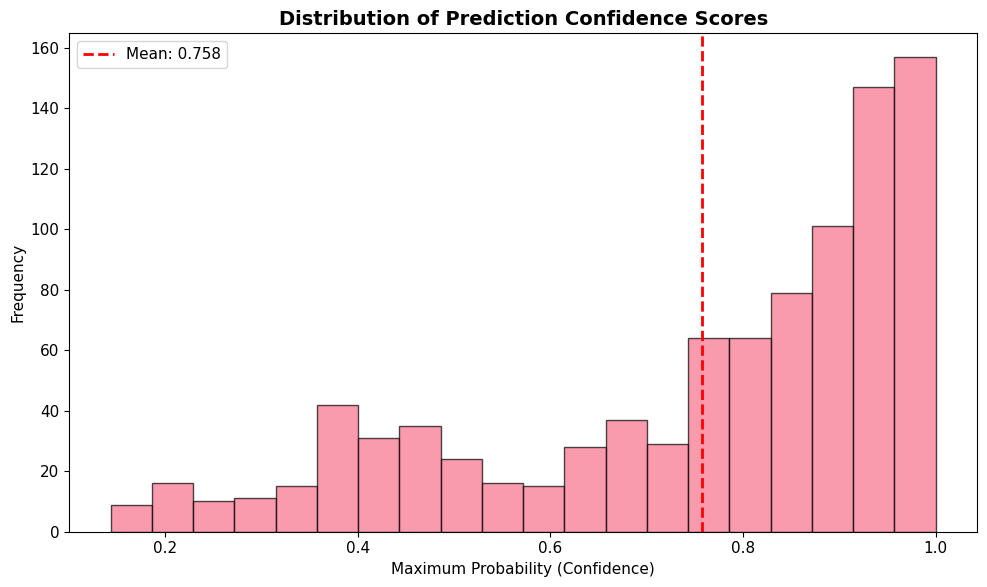

In [25]:
# Plot prediction confidence distribution
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(max_probabilities, bins=20, alpha=0.7, edgecolor='black')
ax.axvline(max_probabilities.mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {max_probabilities.mean():.3f}')
ax.set_title('Distribution of Prediction Confidence Scores', fontsize=14, fontweight='bold')
ax.set_xlabel('Maximum Probability (Confidence)')
ax.set_ylabel('Frequency')
ax.legend()
plt.tight_layout()
plt.show()

In [26]:
# Show some example predictions
print("\n=== EXAMPLE PREDICTIONS ===")
n_examples = min(10, len(y_test))
for i in range(n_examples):
    true_label = y_test[i]
    pred_label = y_test_pred[i]
    confidence = max_probabilities[i]
    correct = "✓" if true_label == pred_label else "✗"
    print(f"\n{correct} Sample {i+1}:")
    print(f"  True: {true_label}")
    print(f"  Predicted: {pred_label} (confidence: {confidence:.3f})")


=== EXAMPLE PREDICTIONS ===

✓ Sample 1:
  True: ENVO:01000843
  Predicted: ENVO:01000843 (confidence: 0.945)

✓ Sample 2:
  True: ENVO:01000888
  Predicted: ENVO:01000888 (confidence: 0.896)

✓ Sample 3:
  True: ENVO:01000816
  Predicted: ENVO:01000816 (confidence: 0.838)

✗ Sample 4:
  True: ENVO:01001057
  Predicted: ENVO:00005801 (confidence: 0.544)

✓ Sample 5:
  True: ENVO:01000843
  Predicted: ENVO:01000843 (confidence: 0.898)

✓ Sample 6:
  True: ENVO:01000892
  Predicted: ENVO:01000892 (confidence: 0.900)

✓ Sample 7:
  True: ENVO:01000869
  Predicted: ENVO:01000869 (confidence: 0.985)

✗ Sample 8:
  True: ENVO:01001057
  Predicted: ENVO:00005801 (confidence: 0.499)

✓ Sample 9:
  True: ENVO:01000888
  Predicted: ENVO:01000888 (confidence: 0.967)

✓ Sample 10:
  True: ENVO:01000816
  Predicted: ENVO:01000816 (confidence: 0.827)


## Summary and Conclusions

In [27]:
# Train RF on version WITH duplicates for comparison
print("=== TRAINING RF ON VERSION WITH DUPLICATES ===\n")

# Prepare data with duplicates
df_clean_with_dupes = df_with_duplicates[df_with_duplicates['google_earth_embeddings'].notna() &
                                          df_with_duplicates['env_local_scale'].notna()].copy()
df_clean_with_dupes['ge_embedding'] = df_clean_with_dupes['google_earth_embeddings'].apply(parse_embedding)
df_clean_with_dupes = df_clean_with_dupes[df_clean_with_dupes['ge_embedding'].notna()].copy()

print(f"Samples with duplicates: {len(df_clean_with_dupes)}")
print(f"Samples deduplicated: {len(df_clean)}")
print(f"Difference: {len(df_clean_with_dupes) - len(df_clean)} samples ({(len(df_clean_with_dupes) - len(df_clean))/len(df_clean_with_dupes)*100:.1f}%)\n")

# Create feature matrix and target
X_with_dupes = np.vstack(df_clean_with_dupes['ge_embedding'].values)
y_with_dupes = df_clean_with_dupes['env_local_scale'].values

# Train/test split
X_train_dupes, X_test_dupes, y_train_dupes, y_test_dupes = train_test_split(
    X_with_dupes, y_with_dupes, test_size=0.2, random_state=RANDOM_STATE
)

print(f"Training set (with duplicates): {len(X_train_dupes)} samples")
print(f"Test set (with duplicates): {len(X_test_dupes)} samples\n")

# Train model
rf_with_dupes = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_with_dupes.fit(X_train_dupes, y_train_dupes)

# Evaluate
y_train_pred_dupes = rf_with_dupes.predict(X_train_dupes)
y_test_pred_dupes = rf_with_dupes.predict(X_test_dupes)
train_accuracy_dupes = accuracy_score(y_train_dupes, y_train_pred_dupes)
test_accuracy_dupes = accuracy_score(y_test_dupes, y_test_pred_dupes)

print("=== MODEL PERFORMANCE (WITH DUPLICATES) ===")
print(f"Training accuracy: {train_accuracy_dupes:.3f}")
print(f"Test accuracy: {test_accuracy_dupes:.3f}")
print(f"Overfitting (train - test): {train_accuracy_dupes - test_accuracy_dupes:.3f}")


=== TRAINING RF ON VERSION WITH DUPLICATES ===

Samples with duplicates: 8121
Samples deduplicated: 4646
Difference: 3475 samples (42.8%)

Training set (with duplicates): 6496 samples
Test set (with duplicates): 1625 samples

=== MODEL PERFORMANCE (WITH DUPLICATES) ===
Training accuracy: 0.928
Test accuracy: 0.886
Overfitting (train - test): 0.042


In [28]:
# Side-by-side comparison
print("=== DEDUPLICATION IMPACT COMPARISON ===\n")

comparison_df = pd.DataFrame({
    'Metric': [
        'Training samples',
        'Test samples',
        'Total samples',
        'Training accuracy',
        'Test accuracy',
        'Overfitting (Δ)',
    ],
    'With Duplicates': [
        len(X_train_dupes),
        len(X_test_dupes),
        len(X_with_dupes),
        f"{train_accuracy_dupes:.3f}",
        f"{test_accuracy_dupes:.3f}",
        f"{train_accuracy_dupes - test_accuracy_dupes:.3f}",
    ],
    'Deduplicated': [
        len(X_train),
        len(X_test),
        len(X),
        f"{train_accuracy:.3f}",
        f"{test_accuracy:.3f}",
        f"{train_accuracy - test_accuracy:.3f}",
    ]
})

print(comparison_df.to_string(index=False))

print("\n=== KEY FINDINGS ===")
acc_change = test_accuracy - test_accuracy_dupes
overfit_change = (train_accuracy - test_accuracy) - (train_accuracy_dupes - test_accuracy_dupes)

if acc_change > 0.01:
    print(f"✓ Deduplication IMPROVED test accuracy by {acc_change:.3f} ({acc_change*100:.1f}%)")
elif acc_change < -0.01:
    print(f"⚠ Deduplication DECREASED test accuracy by {abs(acc_change):.3f} ({abs(acc_change)*100:.1f}%)")
else:
    print(f"~ Deduplication had minimal impact on test accuracy ({acc_change:+.3f})")

if overfit_change > 0.02:
    print(f"⚠ Deduplication INCREASED overfitting by {overfit_change:.3f}")
elif overfit_change < -0.02:
    print(f"✓ Deduplication REDUCED overfitting by {abs(overfit_change):.3f}")
else:
    print(f"~ Deduplication had minimal impact on overfitting ({overfit_change:+.3f})")

print(f"\n📊 Dataset reduced by {len(df_clean_with_dupes) - len(df_clean)} samples ({(len(df_clean_with_dupes) - len(df_clean))/len(df_clean_with_dupes)*100:.1f}%)")
print(f"   Removed {len(df_clean_with_dupes) - len(df_clean)} exact replicates (same coords + same ENVO)")
print(f"   Kept {coords_with_different_envo} samples with annotation conflicts (same coords, different ENVO)")

=== DEDUPLICATION IMPACT COMPARISON ===

           Metric With Duplicates Deduplicated
 Training samples            6496         3716
     Test samples            1625          930
    Total samples            8121         4646
Training accuracy           0.928        0.934
    Test accuracy           0.886        0.834
  Overfitting (Δ)           0.042        0.100

=== KEY FINDINGS ===
⚠ Deduplication DECREASED test accuracy by 0.052 (5.2%)
⚠ Deduplication INCREASED overfitting by 0.057

📊 Dataset reduced by 3475 samples (42.8%)
   Removed 3475 exact replicates (same coords + same ENVO)
   Kept 367 samples with annotation conflicts (same coords, different ENVO)


## Deduplication Impact Analysis (Issue #54)

Now let's compare performance WITH vs WITHOUT duplicates to understand the impact of removing exact replicates.

In [29]:
print("=== EXPERIMENT SUMMARY ===")
print(f"\nDataset:")
print(f"  - Total samples: {len(df_clean)}")
print(f"  - Training samples: {len(X_train)}")
print(f"  - Test samples: {len(X_test)}")
print(f"  - Number of classes: {len(np.unique(y))}")
print(f"  - Feature dimensions: {X.shape[1]}")

print(f"\nModel:")
print(f"  - Algorithm: Random Forest Classifier")
print(f"  - Number of trees: {rf_classifier.n_estimators}")
print(f"  - Max depth: {rf_classifier.max_depth}")

print(f"\nPerformance:")
print(f"  - Training accuracy: {train_accuracy:.3f}")
print(f"  - Test accuracy: {test_accuracy:.3f}")
print(f"  - Mean prediction confidence: {max_probabilities.mean():.3f}")

print(f"\nKey Findings:")
if test_accuracy > 0.7:
    print("  ✓ Google Earth embeddings show STRONG predictive power for ENVO local scale")
elif test_accuracy > 0.5:
    print("  ~ Google Earth embeddings show MODERATE predictive power for ENVO local scale")
else:
    print("  ✗ Google Earth embeddings show LIMITED predictive power for ENVO local scale")

if train_accuracy - test_accuracy > 0.2:
    print("  ⚠ Significant overfitting detected - model may not generalize well")
elif train_accuracy - test_accuracy > 0.1:
    print("  ⚠ Moderate overfitting - consider regularization")
else:
    print("  ✓ Good generalization - minimal overfitting")

=== EXPERIMENT SUMMARY ===

Dataset:
  - Total samples: 4646
  - Training samples: 3716
  - Test samples: 930
  - Number of classes: 51
  - Feature dimensions: 64

Model:
  - Algorithm: Random Forest Classifier
  - Number of trees: 100
  - Max depth: 10

Performance:
  - Training accuracy: 0.934
  - Test accuracy: 0.834
  - Mean prediction confidence: 0.758

Key Findings:
  ✓ Google Earth embeddings show STRONG predictive power for ENVO local scale
  ✓ Good generalization - minimal overfitting
